### Importing Dependencies

In [37]:
import matplotlib.pyplot as plt 
import tensorflow as tf 

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import warnings
warnings.filterwarnings('ignore')

In [38]:
# Importing TF Datasets for the Fashion MNIST dataset
import tensorflow_datasets as tfds

# Importing matplotlib for Viz Stuff
import matplotlib.pyplot as plt

In [39]:
# Using the TensorFlow Dataset API to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

In [40]:
ds.as_numpy_iterator().next()['label']

2

#### Visualizing Data and Building Dataset

In [41]:
# Transofrmations
import numpy as np

In [42]:
# Setup an iterator
data_iterator = ds.as_numpy_iterator()

In [43]:
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

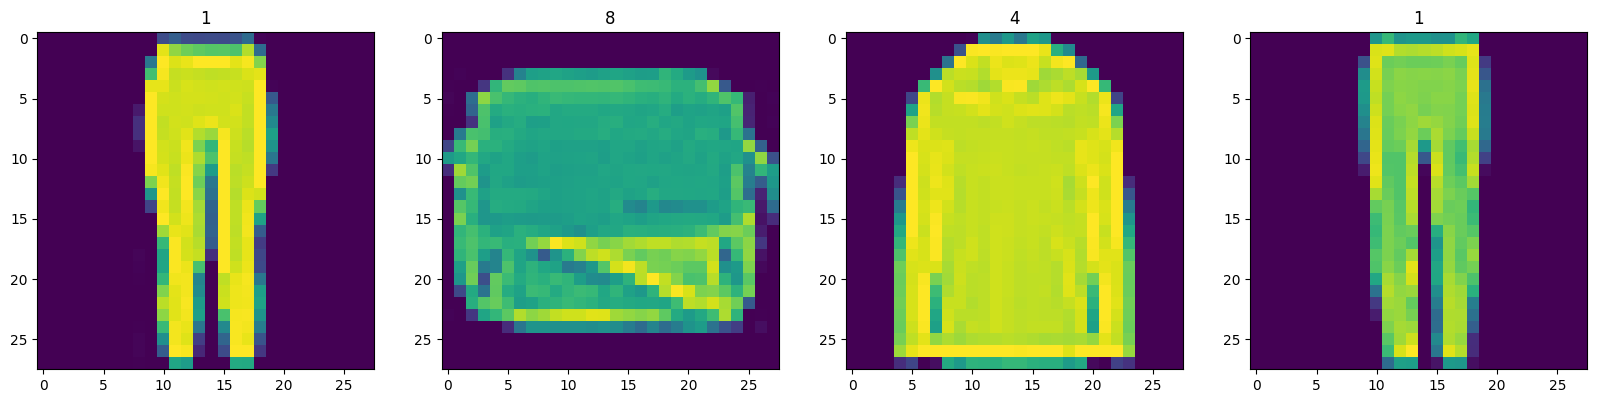

In [44]:
# Subplot Formatting (4 columns, 20x20 pixel size)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Looping to see the images
for idx in range(4):
    # Grabbing image and labelling
    sample = data_iterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    # Setting the title
    ax[idx].title.set_text(sample['label'])

In [45]:
# Scale and return images only
def scale_images(data):
    # Extracting the image only (not the label)
    image = data['image']
    # Scaling the image to be between 0 and 1 since the 
    # max size an image array can have is 255
    return image / 255 

##### Data Pipeline

In [46]:
# Loading/Reloading the Dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing function
ds = ds.map(scale_images)
# Caching the dataset for that batch
ds = ds.cache()
# Shuffling the dataset
ds = ds.shuffle(60000)
# Batching it into batches of 128 images
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [47]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

Looks good.

## Building the Neural Network

<b>Two</b> things to build:

* <b>The Generator:</b> The image Generator which will try to forge images
* <b>The Discrimnator:</b> The police which will try to catch The Generator forging images.

<b>Generator's job:</b> To fool the Discriminator.

<b>Discrimator's job:</b> To catch generator's forgery without getting fooled.

PS. We are making a non-conditional GAN.

#### Importing Modelling Components

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

#### Building the Generator

In [49]:
def build_generator():
    model = Sequential()

    # Takes in random values and then reshapes it to a 7x7x128
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling Block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling Block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv Block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv Block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv Layer to 1 channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [50]:
generator = build_generator()

In [51]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [58]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 42ms/step


(4, 28, 28, 1)

1/1 [==============================] - 0s 34ms/step


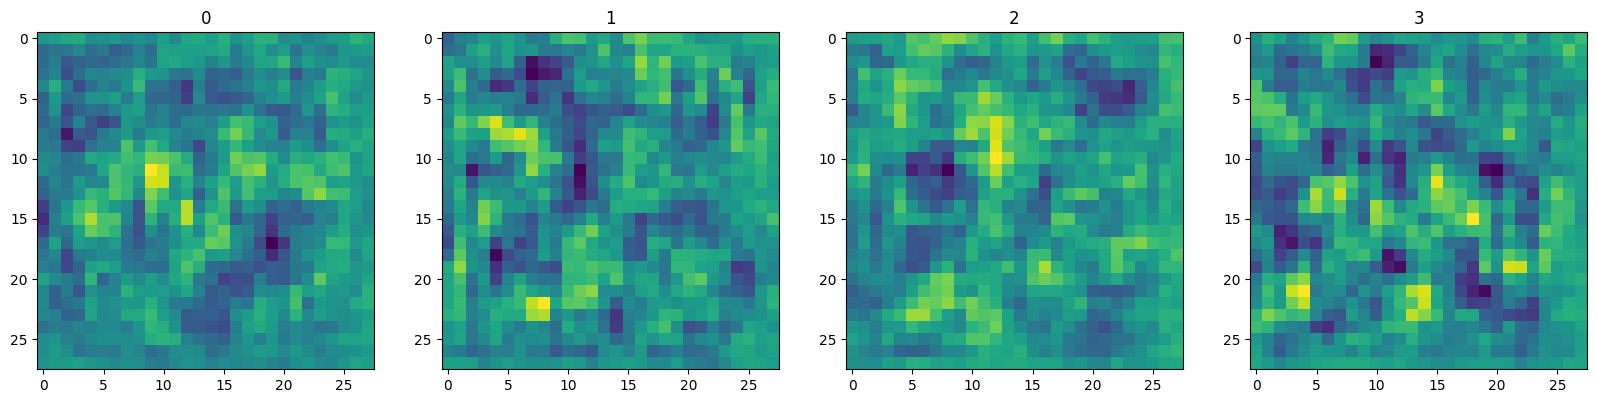

In [53]:
img = generator.predict(np.random.randn(4,128,1))
# Subplot Formatting (4 columns, 20x20 pixel size)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Looping to see the images
for idx, img in enumerate(img):    
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Setting the title
    ax[idx].title.set_text(idx)

Okay, looks pretty bad for now.

But it should look better after training, <b>hopefully.</b>

#### Building the Discriminator

In [54]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape =(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(265, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten and pass to Dense Layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [55]:
discriminator = build_discriminator()

In [56]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)      

Example of the Discriminator giving a value between 1 and 0 to predict if the Generated image is REAL or FAKE. Correct or incorrect.

In [59]:
discriminator.predict(img)

1/1 [==============================] - 0s 81ms/step


array([[0.50031674],
       [0.5001453 ],
       [0.50021964],
       [0.5004259 ]], dtype=float32)

### Constructing Custom Training Loop

##### Setting up Losses and Optimizers

In [60]:
# Adam optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary Cross Entropy for both
from tensorflow.keras.losses import BinaryCrossentropy

In [61]:
# Generator Optimizer (Faster than Discriminator)
g_opt = Adam(learning_rate=0.0001)
# Discriminator Optimizer (Faster than Discriminator)
d_opt = Adam(learning_rate=0.00001)

# Losses for both are same
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### Building Subclassed Model

In [62]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [87]:
class GAN_Fashion(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Passing through args and kwards to base class (Model)
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Passing through args and kwards to base class (Model)
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Getting the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Training the discrimator 
        with tf.GradientTape() as d_tape:
            
            # Pass the real and fake images to the Discriminator
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels fo real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculating Loss - Binary Cross Entropy
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)


        # Applying backpropogation - nn Learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate Loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [88]:
# Creating an instance of the subclassed model
fashgan = GAN_Fashion(generator, discriminator)

In [89]:
# Compiling the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

##### Building Callback

In [90]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [96]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

##### Training

In [97]:
# Recommended: 2000, For now, trained on: 1 since it takes me 27 mins
# to finish one epoch of training.
hist = fashgan.fit(ds, epochs=1, callbacks=[ModelMonitor()])

469/469 [==============================] - 1619s 3s/step - d_loss: 0.6781 - g_loss: 0.7512


##### Reviewing the Performance

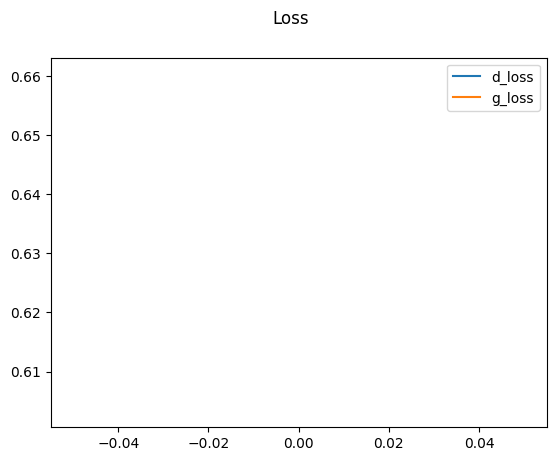

In [99]:
# Please look at the graph after training the model for more epochs!
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

##### Generating Images

In [104]:
imgs = generator.predict(tf.random.normal((2, 128, 1)))

1/1 [==============================] - 0s 29ms/step


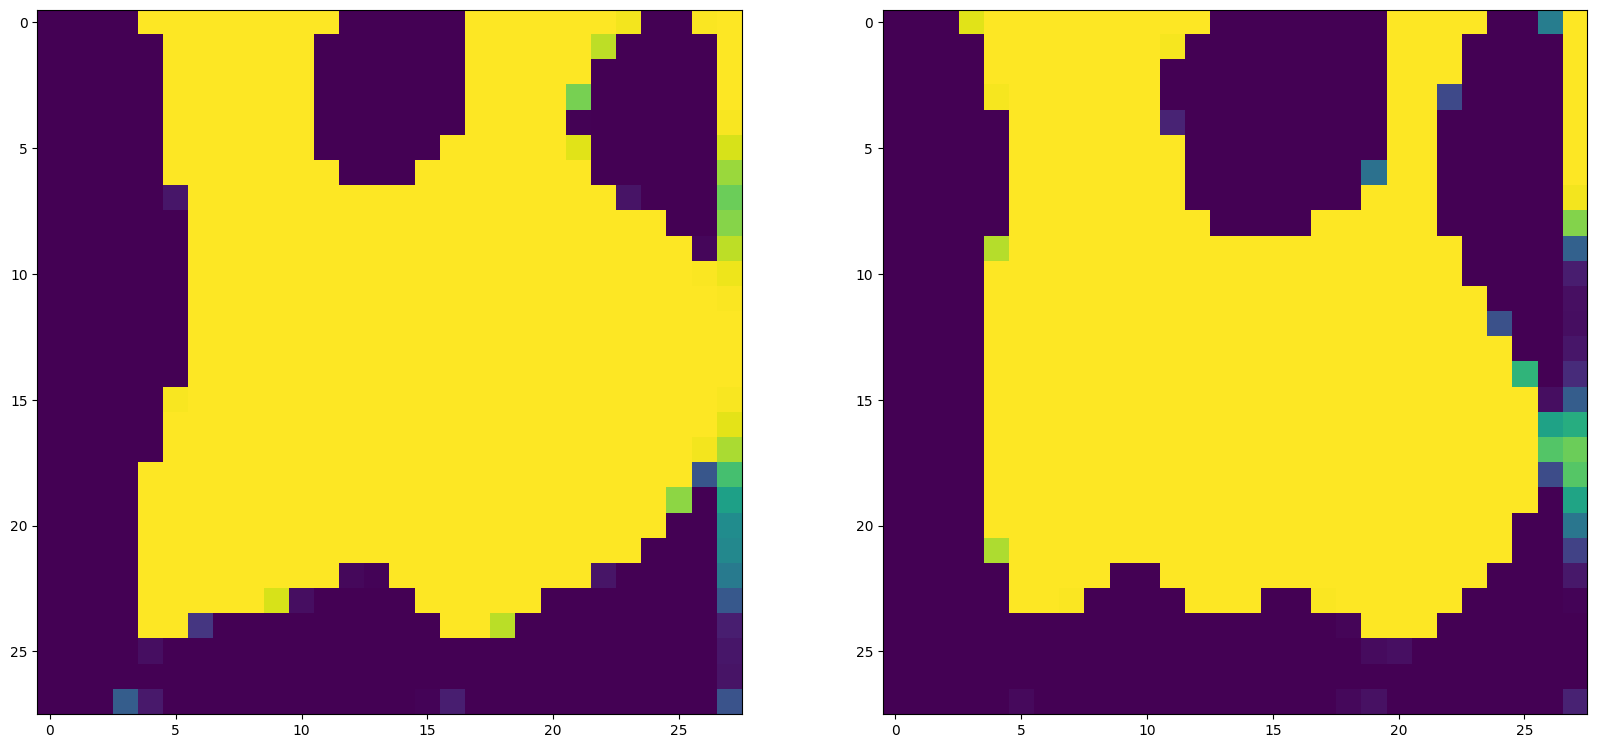

In [109]:
fig, ax = plt.subplots(ncols=2, figsize=(20,20))
for r in range(2):
    ax[r].imshow(imgs[(r+1)-1])

Pretty bad at the moment, but should look better once trained on more epochs!

#### Saving the model

In [110]:
generator.save('generator-1epoch.h5')
discriminator.save('discriminator-1epoch.h5')